This is a notebook covering the basic code behind demodulation. 

QUICK SUMMARY:
It begins with opening a pickle file (how the data is saved while being recorded). The necessary values are drawn from the pickle file (such as the frequency of samples, speed of the carriage, scan time etc.) These are used to get use appropriate units.

The first Plot (Plot 1) is of the original data. A power of 2 samples ($2^i$) is chosen and then fourier transformed leading to Plot 2. 

The center peak is the carrier wave, and the two lobes at the side are used for demodulation. The two lobes at the side are the spectrum that we want for a demodulated interferogram. The carrier wave spectrum is Plot 3.

The carrier wave spectrum (plot 3) is then cyclically shifted so that the carrier is centered at zero. In this code the 'max' value is used as the approximation of the center of the carrier. It is then multiplied by a hanning function to reduce noise. This leads to Plot 4. 

Plot 4 is then inverse fourier transformed leading to a demodulated but cyclically shifted (as expected) interferogram, which is shown in Plot 5.

This is then cyclically shifted back to the original, producing the demodulated interferogram. (Plot 6).

A comparison of the two is shown at the end.

Mira

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
#%matplotlib inline
import pickle
import sys
import numpy as np
import scipy.optimize as op
from scipy.optimize import curve_fit

In [3]:
with open( '../../data/raw_data/20170615_1658_2mms_90DHW_chopped.pkl' , 'rb') as f:
    d = pickle.load(f, encoding='latin1') 

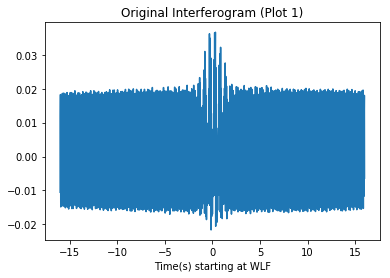

In [4]:
i = 11
Nsize = 2**i
dt=(1/(d['sample freq'])) #period
T1=dt*(Nsize) #full period
v=(d['speed'])
X = v*T1 #full distance
dx = dt*v #smallest amount of distance travelled
total_t = (d['scan time']) #how long it ran
    
total_s = (d['samples requested']) #number of samples 
startpt = ((total_s - Nsize)/2) #starting point


endpt = startpt + Nsize #ending point
startpt = int(startpt)
endpt = int(endpt)

df = 1/T1
f = df*np.arange(Nsize/2)+df/2.0
fFull = df*np.arange((Nsize/2) + 1)+df/2.0


y = (d['sig0F'])
D = y[startpt:endpt]
#D = np.flipud(D)

a = d['delay0F']/v
t = a[startpt:endpt]

pl.plot(t,D) #cut off
pl.title('Original Interferogram (Plot 1)')
pl.xlabel('Time(s) starting at WLF')
pl.show()
#pl.plot(a,y)

In [5]:
def maxX(x,y):
    maxy = max(y)
    maxx = x[y.argmax()]  # Find the x value corresponding to the maximum y value
    return 300*maxx, maxy, y.argmax()

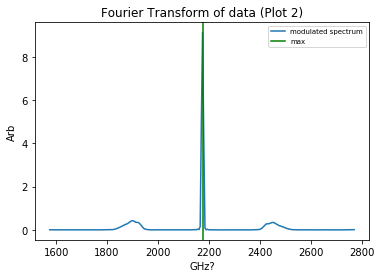

sample frequency is  64.0
2175.0


In [6]:
D = np.hanning(Nsize)*D
S = np.fft.rfft(D)
S = S[0:-1]
u = np.abs(S)
dNu = 1/(Nsize*dx)
Nu = dNu*np.arange(Nsize/2)

i1 = 8
Nsize1 = 2**i1
startpt1 = (maxX(Nu,u)[2]- (Nsize1)/2)
endpt1 = startpt1 + Nsize1 #ending point
startpt1 = int(startpt1)
endpt1 = int(endpt1)

pl.plot(300*Nu[startpt1:endpt1], u[startpt1:endpt1], label = 'modulated spectrum')
pl.title('Fourier Transform of data (Plot 2)')
#pl.xlim(0,2000)
pl.xlabel('GHz?')
pl.ylabel('Arb')
pl.axvline(x = maxX(Nu,u)[0], color = 'green', label = 'max')
pl.legend(fontsize = 'x-small')
pl.show()
fs = d['sample freq']
print ('sample frequency is ', fs)
x = maxX(Nu,u)[0]
print (x)

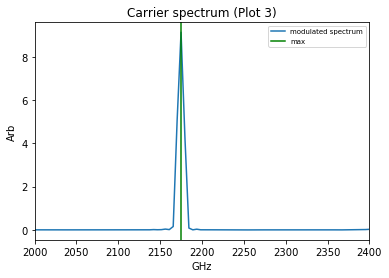

In [7]:
pl.plot(300*Nu[startpt1:endpt1], u[startpt1:endpt1], label = 'modulated spectrum')
pl.title('Carrier spectrum (Plot 3)')
pl.xlim(2000,2400)
pl.xlabel('GHz')
pl.ylabel('Arb')
pl.axvline(x = maxX(Nu,u)[0], color = 'green', label = 'max')
pl.legend(fontsize = 'x-small')
pl.show()
#location of the maximum on the x axis

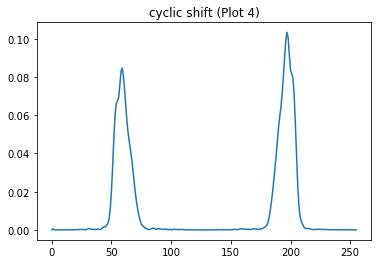

In [8]:
uNew = (np.fft.ifftshift(u[startpt1:endpt1]*np.hanning(Nsize1)))
pl.plot(uNew*np.hanning(Nsize1))
pl.title('cyclic shift (Plot 4)')
pl.show()

/Users/Lab/anaconda/envs/py3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


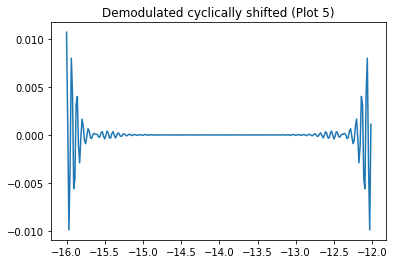

In [9]:
dmod = np.fft.ifft(uNew*np.hanning(Nsize1))
#print ((len(t)) - len(abs(np.fft.fftshift(dmod))))
t2 = t[:-1792]
#len(t2)
pl.plot(t2,dmod)
pl.title('Demodulated cyclically shifted (Plot 5)')
pl.show()

/Users/Lab/anaconda/envs/py3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Lab/anaconda/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


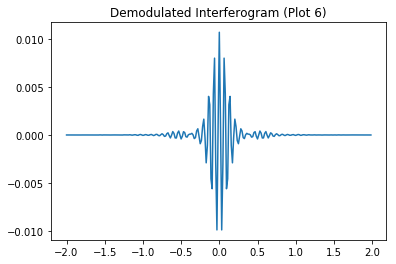

In [10]:
#np.sin(t2*1.6 - .2)*.01 +.018 #frequency, phase, amplitude, offset
#p0 = [1.6, -.2, .01, .018]
#popt, pcov = curve_fit(sine,t2,abs(np.fft.fftshift(dmod)), p0 = p0)
t3 = ([x+14 for x in t2])
pl.plot(t3,np.fft.fftshift(dmod))
#pl.plot(t2,sine(t2,*popt), color = 'green', label = 'fit')
#pl.ylim(0,.5)
pl.legend()
pl.title('Demodulated Interferogram (Plot 6)')
pl.show() #minimum should be at 0
#print (popt[3])

/Users/Lab/anaconda/envs/py3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


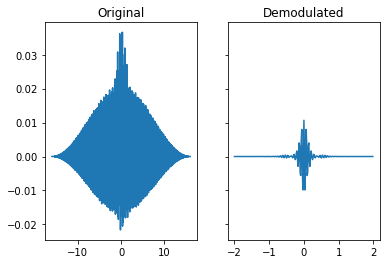

In [11]:
f, (ax1, ax2) = pl.subplots(1, 2, sharey=True)
ax1.plot(t,D)
ax1.set_title('Original')
ax2.plot(t3,np.fft.fftshift(dmod))
ax2.set_title('Demodulated')
pl.show()

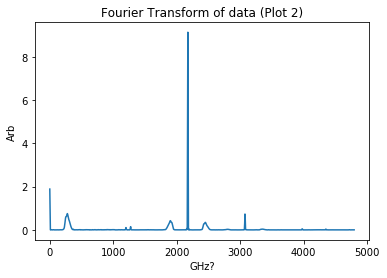

In [12]:

pl.plot(300*Nu, u, label = 'modulated spectrum')
pl.title('Fourier Transform of data (Plot 2)')
#pl.xlim(0,2000)
pl.xlabel('GHz?')
pl.ylabel('Arb')
pl.show()